In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip
from sklearn.metrics import f1_score
from skimage.measure import label, regionprops
import numpy as np
from torchvision import transforms
from sklearn.metrics import f1_score,accuracy_score
import matplotlib.pyplot as plt
#from tqdm import tqdm
import tifffile
import skimage
torch.manual_seed(17)
import random
import time
from patchify import patchify, unpatchify
from skimage import measure
import pandas as pd

In [2]:
def padd_to_proper(data):
    padded_image = np.pad(data[:,:,:], ((2,2), (1,1), (1, 1)), mode='constant') 
    return padded_image

In [3]:
def swape(a):
    swapped_array = a.copy()
    # Replace 0s with 1s and 1s with 0s using boolean indexing
    swapped_array[a == 0] = 1
    swapped_array[a == 1] = 0
    return swapped_array

In [4]:
def f1(pred,target):
    pred = swape(pred)
    target = swape(target)
    
    F1 = round(100*f1_score(pred.astype('uint8').ravel(), target.astype('uint8').ravel()),3)
    return F1
    


In [5]:
data_path ='data/registered/output/fixed_low_res.tif'
data = tifffile.imread(data_path)[1:-2,40:-50,0:-25]
print ('data shape', data.shape)
target_path = 'data/registered/output/registered_mask.tif'
target = tifffile.imread(target_path)[1:-2,40:-50,0:-25]
print ('target shape', target.shape)

UNET_pred_path = 'segmentation_outputs/3D_Unet_results.tif'
UNET_pred = tifffile.imread(UNET_pred_path)[1:-2,40:-50,0:-25]
print ('Unet Pred shape = ', UNET_pred.shape)

data shape (125, 166, 103)
target shape (125, 166, 103)
Unet Pred shape =  (125, 166, 103)


In [6]:


NGMM_path = 'segmentation_outputs/NGMM.tif'
NGMM_pred = tifffile.imread(NGMM_path)
NGMM_pred = padd_to_proper(NGMM_pred)
NGMM_pred[NGMM_pred>0.5] = 1
print ('NGMMPred shape = ', NGMM_pred.shape)

RW_path = 'segmentation_outputs/RW.tif'
RW_pred = tifffile.imread(RW_path)
print ('RW_Pred shape = ', RW_pred.shape)

GrabCut_path = 'segmentation_outputs/GrabCut.tif'
GrabCut_pred = tifffile.imread(GrabCut_path)
print ('GrabCut_pred shape = ', GrabCut_pred.shape)



NGMMPred shape =  (126, 166, 113)
RW_Pred shape =  (125, 166, 103)
GrabCut_pred shape =  (125, 166, 103)


In [7]:
def get_metrics (name,pred, target,voxel=60, ice_density =0.918  ):
    #ice_density (g/cm3)
    # Prediction accuracy
    #F1 score is calculated with swaped indecies so a buble is 1 and ice is zero
    F1_Score = f1(pred,target)
    ACC = round(100*accuracy_score(pred.astype('uint8').ravel(), target.astype('uint8').ravel()),3)
    # Microstructure parameters
    relative_density = round(len(pred[pred>0])/pred.size,3)
    density = relative_density * ice_density
    
    porosity = round (len (pred[pred==0])*100/pred.size,3)
    
    
    label_img = label(pred.astype('uint8'), connectivity=2,background = 1)
    props = regionprops(label_img)
    N_bubles = len(np.unique(label_img))
    Avg_area = np.array([i['area'] for i in props[:]]).mean()
    Avg_area =round( (Avg_area * voxel * voxel * voxel)/10e8,5)
    
    verts, faces, _, _ = measure.marching_cubes(pred, level=0)
    surface_area = measure.mesh_surface_area(verts, faces)
    SSA =round( (surface_area * voxel * voxel)/10e5,2) # mm^2
    
    metrics = {'Method':name,'ACC':ACC, 'F1_Score':F1_Score, 'density':density, 'porosity':porosity,
               'N_bubles':N_bubles, 'Avg_bubble_Vol':Avg_area, 'SSA':SSA}
    return metrics

In [8]:
metrics = [get_metrics('Ground Truth',target[5:30,5:-5,5:-5],target[5:30,5:-5,5:-5]),
          get_metrics('NGMM',NGMM_pred[5:30,5:-5,5:-15],target[5:30,5:-5,5:-5]),
           get_metrics('Grab Cut',GrabCut_pred[5:30,5:-5,5:-5],target[5:30,5:-5,5:-5]),
           get_metrics('RW',RW_pred[5:30,5:-5,5:-5],target[5:30,5:-5,5:-5]),
          get_metrics('3D Unet',UNET_pred[5:30,5:-5,5:-5],target[5:30,5:-5,5:-5])]
df = pd.DataFrame(metrics)
df.head()

,Method,ACC,F1_Score,density,porosity,N_bubles,Avg_bubble_Vol,SSA
0,Ground Truth,100.000,100.000,0.906984,1.238,72,0.01367,12.76
1,NGMM,99.020,51.626,0.910656,0.788,28,0.02286,7.55
2,Grab Cut,98.980,43.559,0.912492,0.568,28,0.01648,5.33
3,RW,98.976,41.769,0.913410,0.520,26,0.01630,4.89
4,3D Unet,98.728,52.851,0.904230,1.460,43,0.02723,13.65


In [9]:
# Convert DataFrame to LaTeX table format
latex_table = df.to_latex(index=False)

# Output LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrr}
\toprule
      Method &     ACC &  F1\_Score &  density &  porosity &  N\_bubles &  Avg\_bubble\_Vol &   SSA \\
\midrule
Ground Truth & 100.000 &   100.000 & 0.906984 &     1.238 &        72 &         0.01367 & 12.76 \\
        NGMM &  99.020 &    51.626 & 0.910656 &     0.788 &        28 &         0.02286 &  7.55 \\
    Grab Cut &  98.980 &    43.559 & 0.912492 &     0.568 &        28 &         0.01648 &  5.33 \\
          RW &  98.976 &    41.769 & 0.913410 &     0.520 &        26 &         0.01630 &  4.89 \\
     3D Unet &  98.728 &    52.851 & 0.904230 &     1.460 &        43 &         0.02723 & 13.65 \\
\bottomrule
\end{tabular}



C:\Users\Fabagh001\AppData\Local\Temp\ipykernel_106336\2325933311.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)


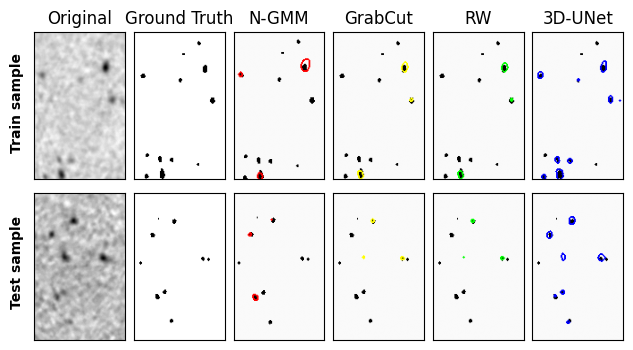

In [11]:
n = 100 #train
m = 20 #test

fig = plt.figure(figsize=(9, 4))
gs = fig.add_gridspec(2, 6, hspace=0.1, wspace=-0.5) #
ll  = gs.subplots()

figures = [
    
    data[n],
    target[n],
    skimage.segmentation.mark_boundaries(target[n,2:-2,2:-2]*250,NGMM_pred[n,2:-2,2:-12], (1,0,0), mode='thick'),
    skimage.segmentation.mark_boundaries(target[n]*250,GrabCut_pred[n], (1,1,0), mode='thick'),
    skimage.segmentation.mark_boundaries(target[n]*250,RW_pred[n], (0,1,0), mode='thick'),
    skimage.segmentation.mark_boundaries(target[n]*250,UNET_pred[n].astype('uint8'), (0,0,1), mode='thick'),
    
    data[m],
    target[m],
    skimage.segmentation.mark_boundaries(target[m,2:-2,2:-2]*250,NGMM_pred[m,2:-2,2:-12], (1,0,0), mode='thick'),
    skimage.segmentation.mark_boundaries(target[m]*250,GrabCut_pred[m], (1,1,0), mode='thick'),
    skimage.segmentation.mark_boundaries(target[m]*250,RW_pred[m], (0,1,0), mode='thick'),
    skimage.segmentation.mark_boundaries(target[m]*250,UNET_pred[m].astype('uint8'), (0,0,1), mode='thick')]


for i , ax in enumerate(fig.get_axes()):
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if len(figures[i].shape) == 2:
        ax.imshow(figures[i],'gray')
    else:
        ax.imshow(figures[i])

        
# Add vertical text to the figure
vertical_text = "Train sample"
x_pos = -20  
y_pos = 80 
# Note that rotation is set to 90 to make the text vertical
fig.get_axes()[0].text(x_pos, y_pos, vertical_text, rotation=90, va='center', ha='center', weight='bold')

# Add vertical text to the figure
vertical_text = "Test sample"
x_pos = -20  
y_pos = 260 
# Note that rotation is set to 90 to make the text vertical
fig.get_axes()[0].text(x_pos, y_pos, vertical_text, rotation=90, va='center', ha='center', weight='bold')

fig.get_axes()[0].set_title('Original')
fig.get_axes()[1].set_title('Ground Truth')
fig.get_axes()[2].set_title('N-GMM')
fig.get_axes()[3].set_title('GrabCut')
fig.get_axes()[4].set_title('RW')
fig.get_axes()[5].set_title('3D-UNet')
plt.savefig('multiple_img.pdf', dpi = 600)